# Import libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.__version__

'0.9.1'

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

In [4]:
save_folder = "/media/Scratch_SSD_Voyager/Blue/KPMP_10X/KPMP_Ref_analysis_12-2020/Celloracle2/Figures"
os.makedirs(save_folder, exist_ok=True)

# Load data

In [5]:
# Load file.
oracle = co.load_hdf5("/media/Scratch_SSD_Voyager/Blue/KPMP_10X/KPMP_Ref_analysis_12-2020/Celloracle2/aTAL_Trajectory.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.8.2
    n_cells: 27721
    n_genes: 3138
    cluster_name: modules
    dimensional_reduction_name: X_umap.traj
    n_target_genes_in_TFdict: 17927 genes
    n_regulatory_in_TFdict: 1092 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 186 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2737 genes
    k_for_knn_imputation: 693
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [6]:
# You can load files with the following command.
links = co.load_hdf5(file_path="/media/Scratch_SSD_Voyager/Blue/KPMP_10X/KPMP_Ref_analysis_12-2020/Celloracle2/aTAL_Trajectory_links.celloracle.links")

# Make predictive models for simulation

In [7]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in black


  0%|          | 0/3138 [00:00<?, ?it/s]

genes_in_gem: 3138
models made for 1355 genes
calculating GRN in blue


  0%|          | 0/3138 [00:00<?, ?it/s]

genes_in_gem: 3138
models made for 1447 genes
calculating GRN in brown


  0%|          | 0/3138 [00:00<?, ?it/s]

genes_in_gem: 3138
models made for 1446 genes
calculating GRN in pink


  0%|          | 0/3138 [00:00<?, ?it/s]

genes_in_gem: 3138
models made for 1359 genes
calculating GRN in yellow


  0%|          | 0/3138 [00:00<?, ?it/s]

genes_in_gem: 3138
models made for 1504 genes


# In silico TF perturbation analysis

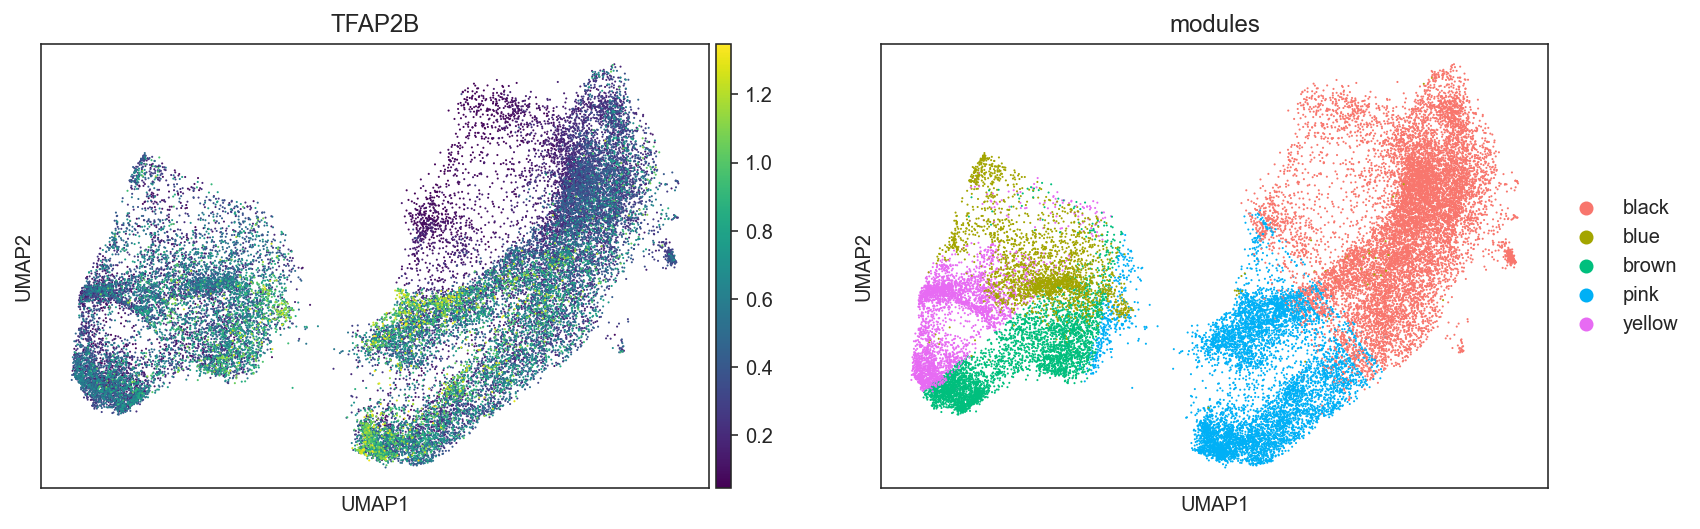

In [8]:
# Check gene expression
goi = "TFAP2B"
sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

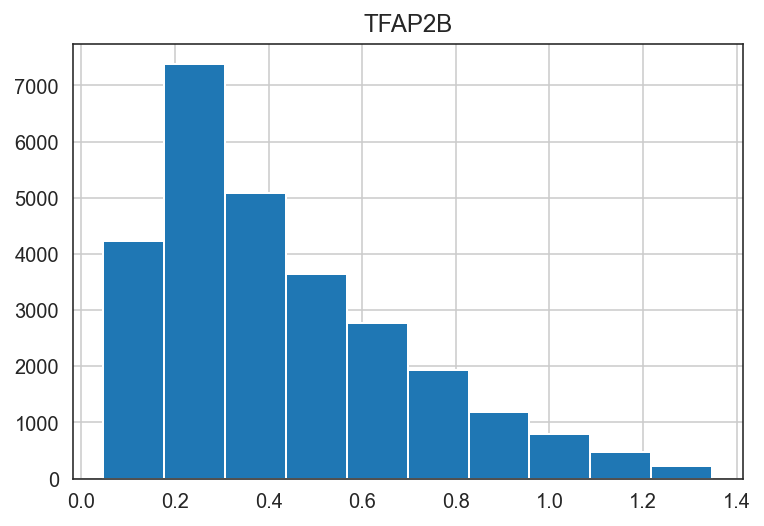

In [9]:
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [10]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [11]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

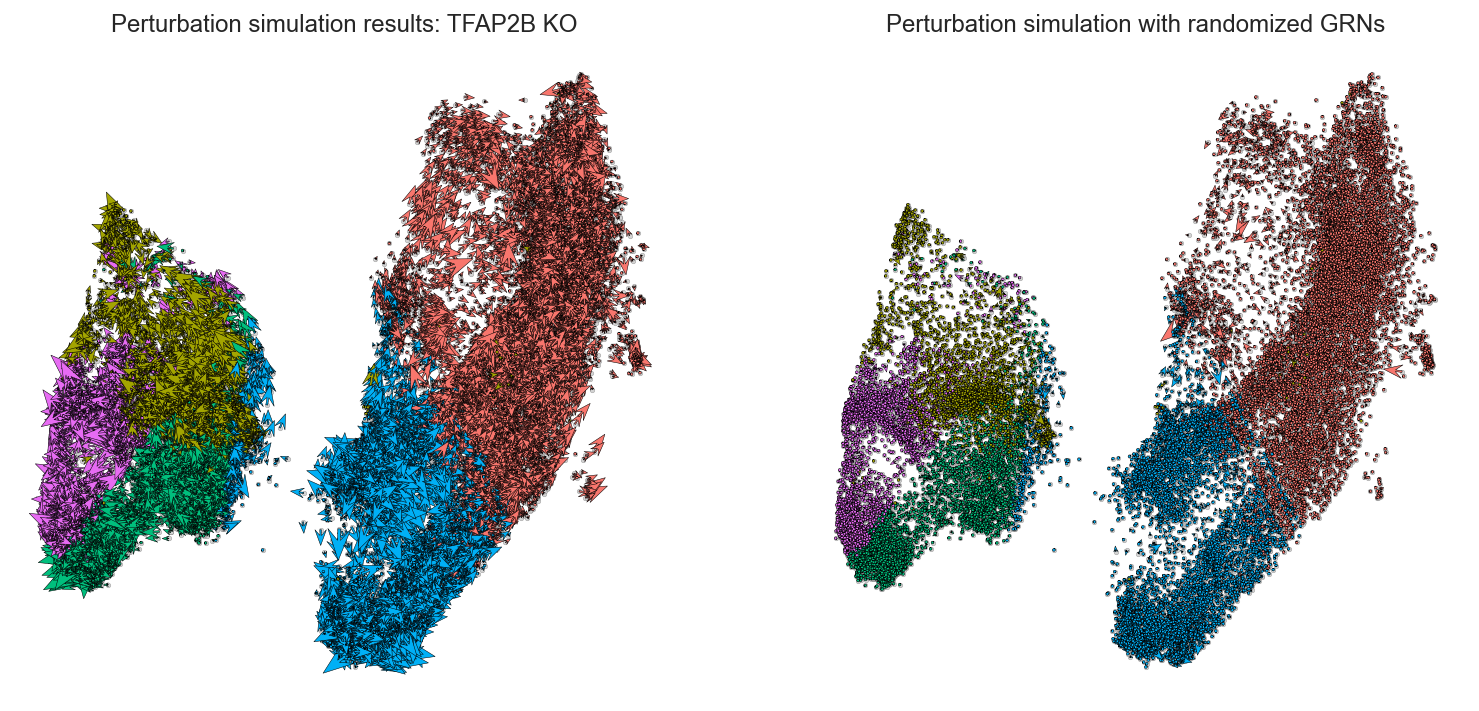

In [12]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Perturbation simulation results: {goi} KO")

# Show quiver plot that was calculated with randomized GRN.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Perturbation simulation with randomized GRNs")

plt.show()

In [13]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

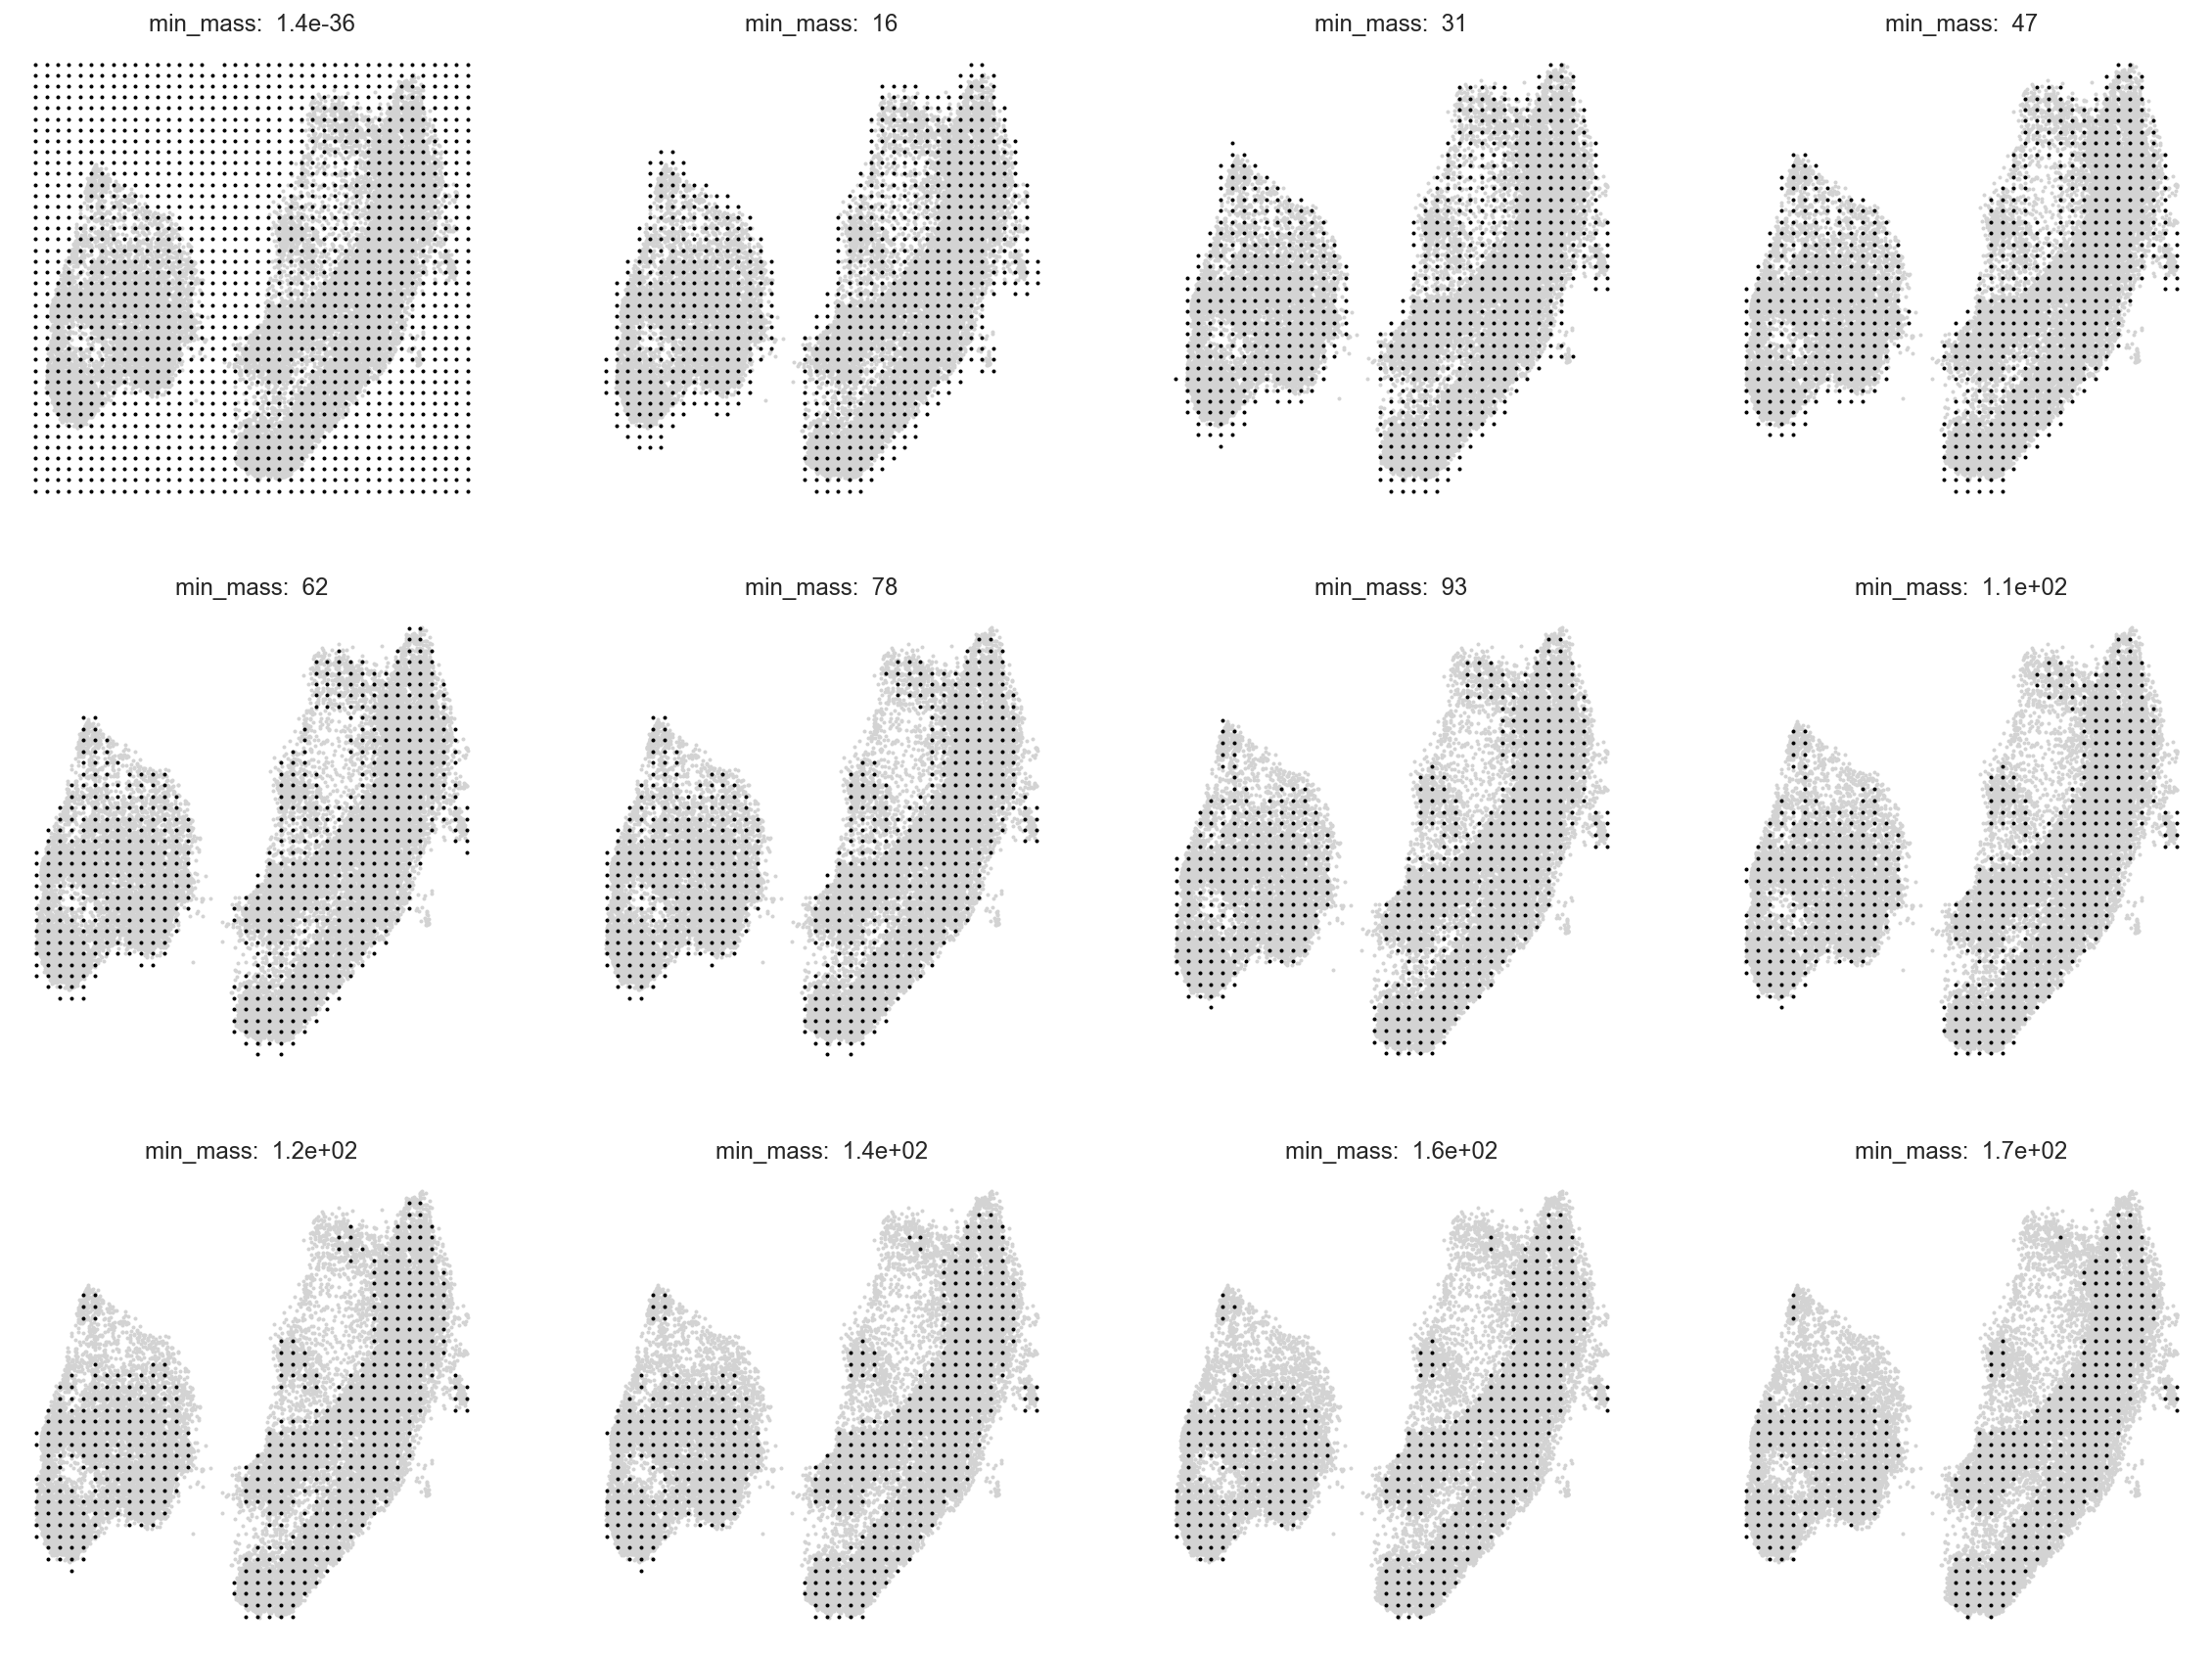

In [14]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

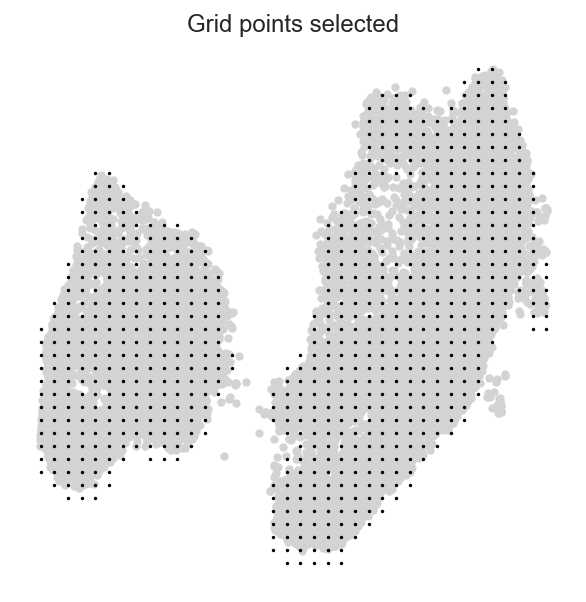

In [15]:
min_mass = 47
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

# Plot vector fields

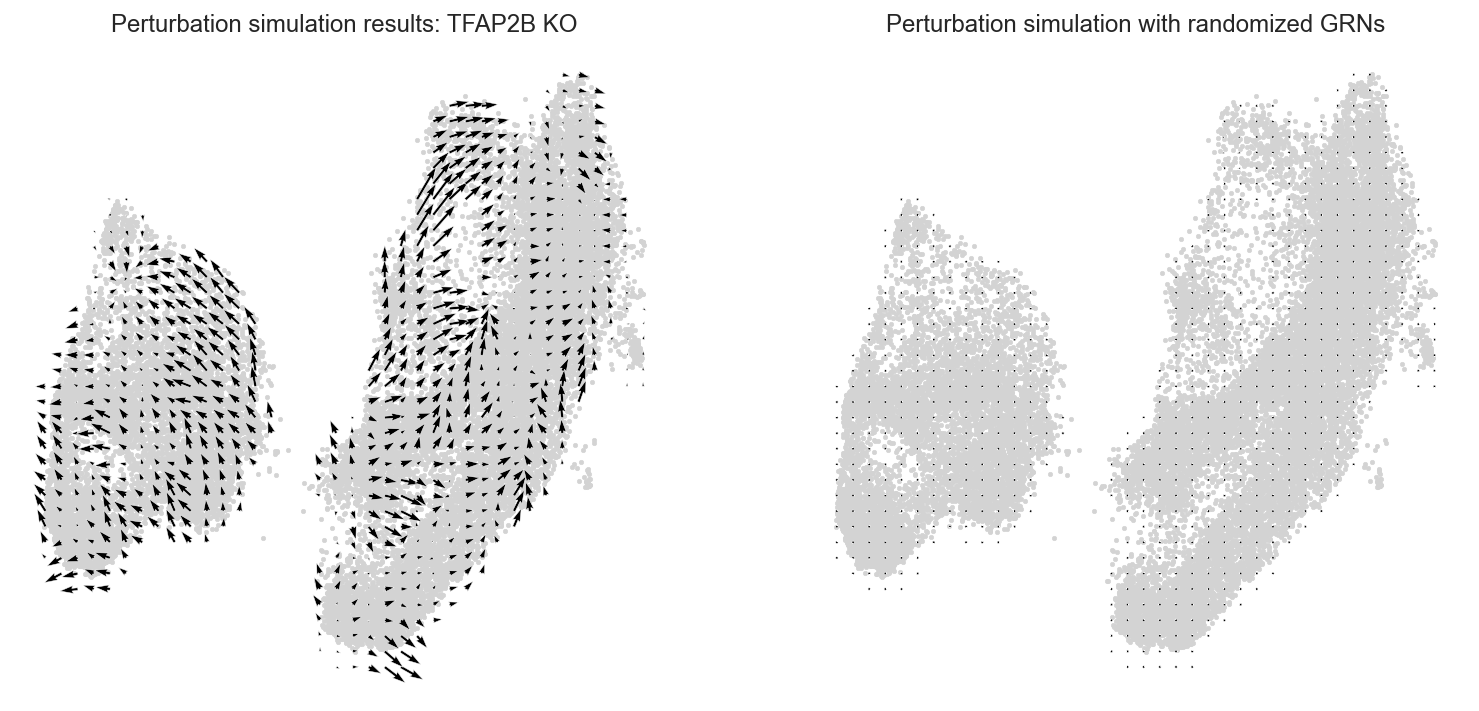

In [16]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 10
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Perturbation simulation results: {goi} KO")

# Show quiver plot that was calculated with randomized GRN.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Perturbation simulation with randomized GRNs")

plt.show()

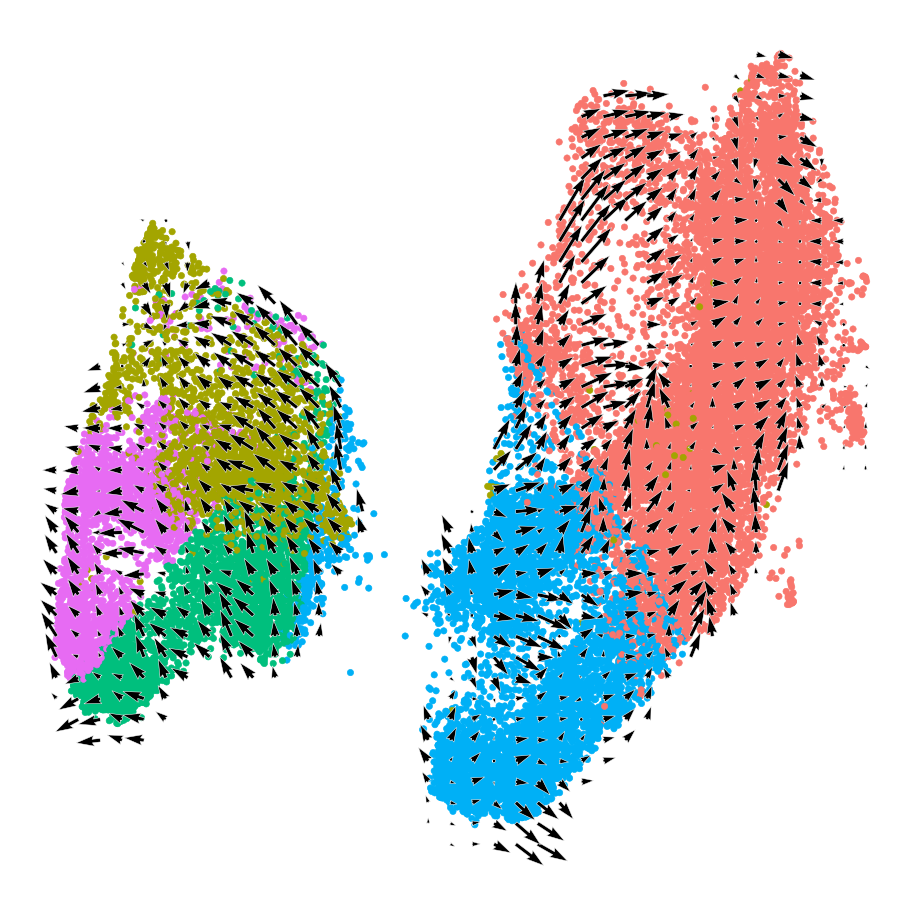

In [17]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [18]:
#Reverse pseudotime
x = oracle.adata.obs['pseudotime']
y = -x + max(x) + min(x)
oracle.adata.obs['pseudotime'] = y

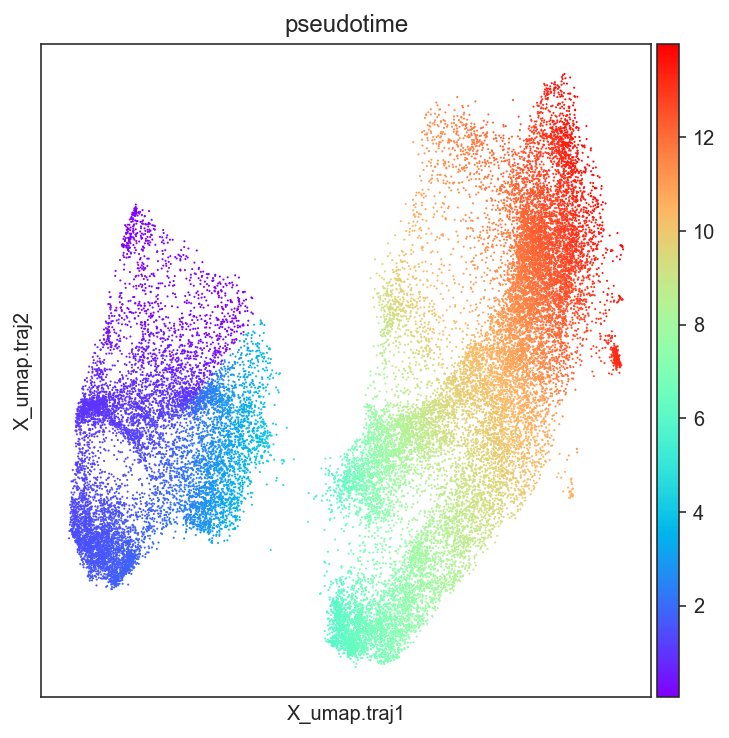

In [19]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["pseudotime"])

In [20]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="pseudotime")

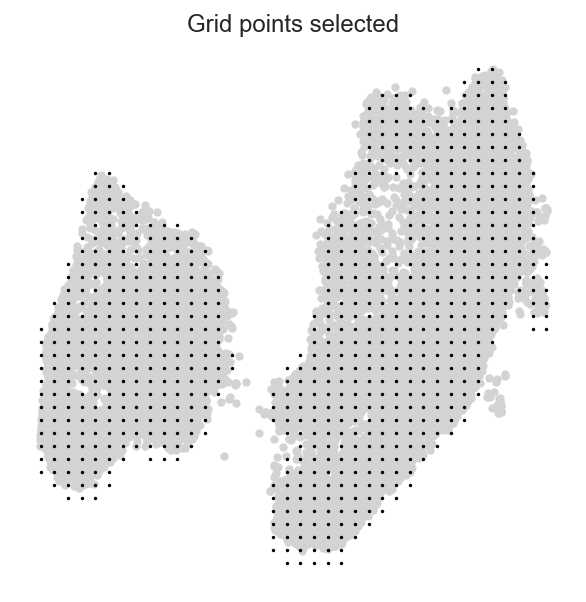

In [21]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

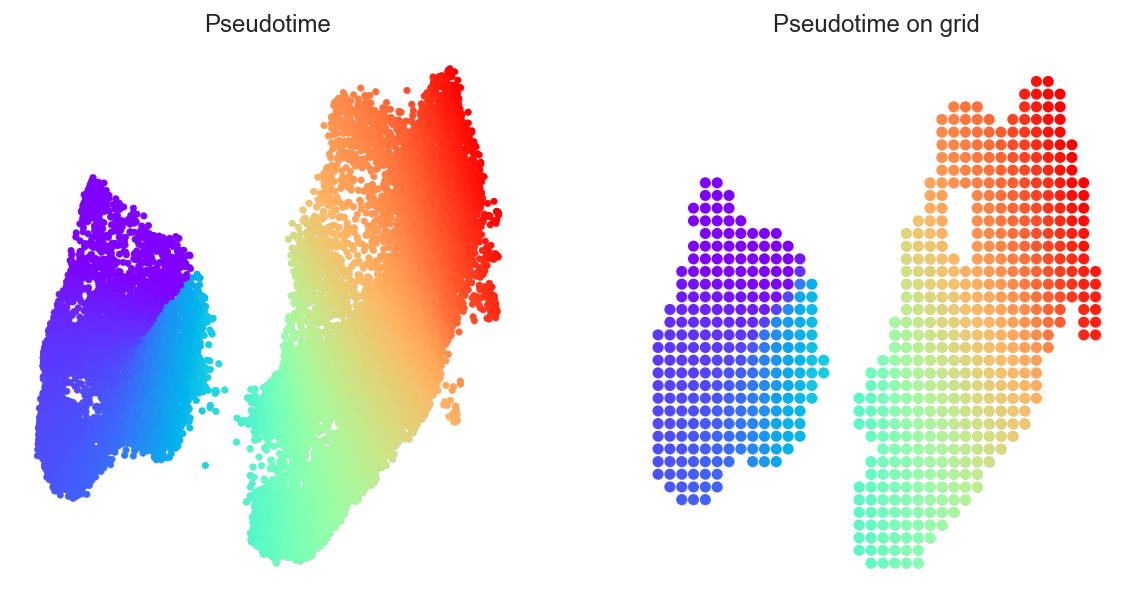

In [22]:
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50}, plot=True)

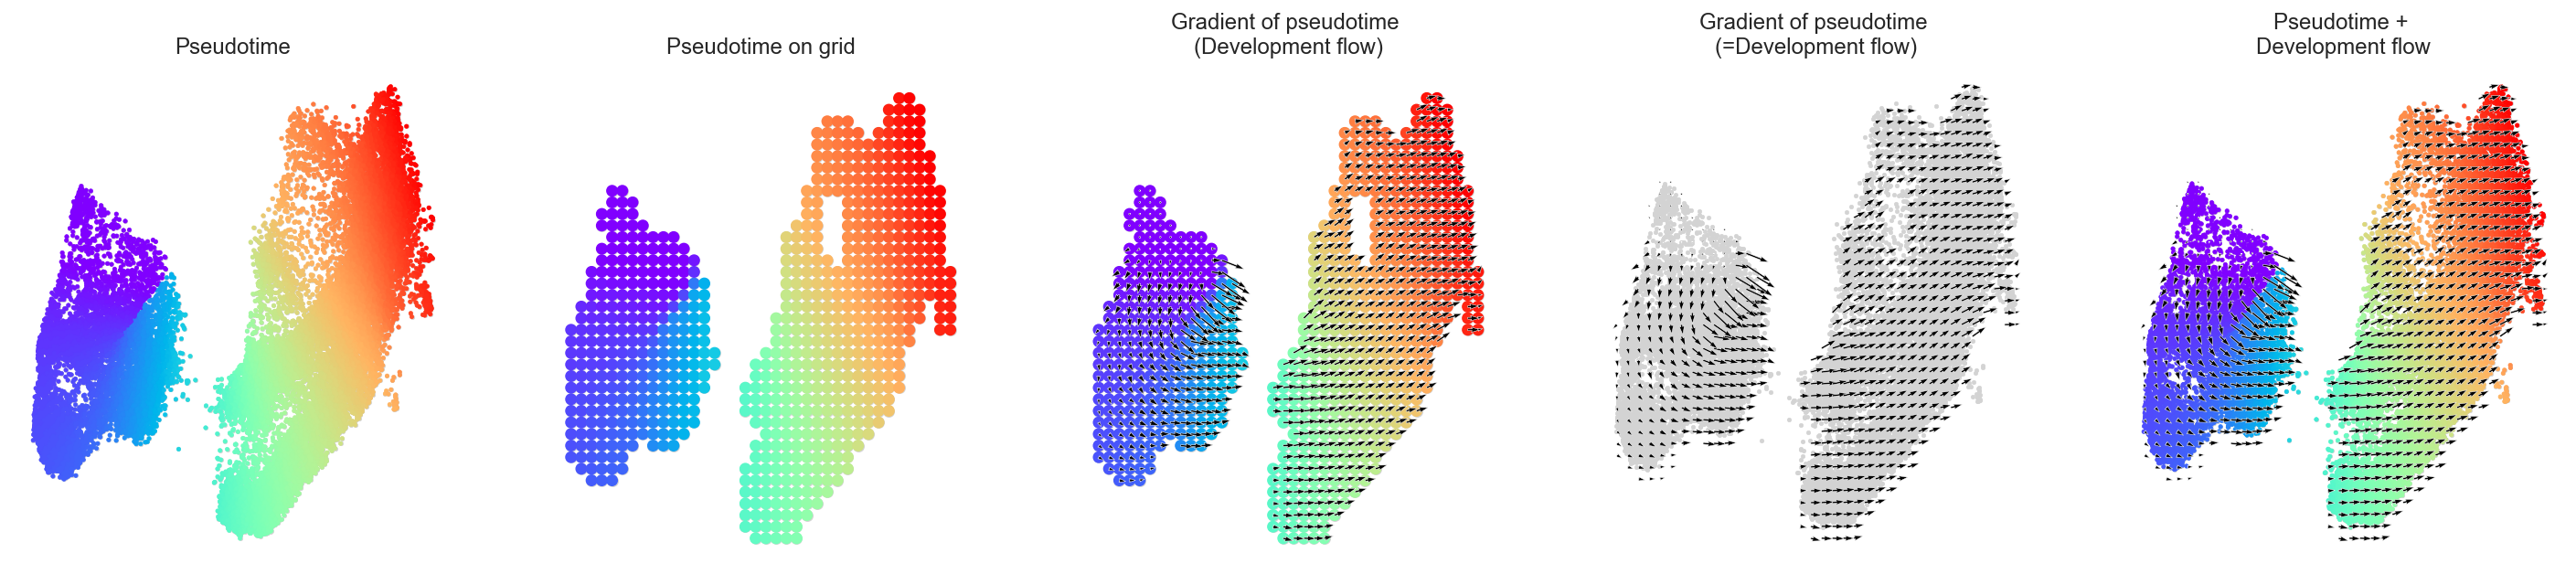

In [58]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

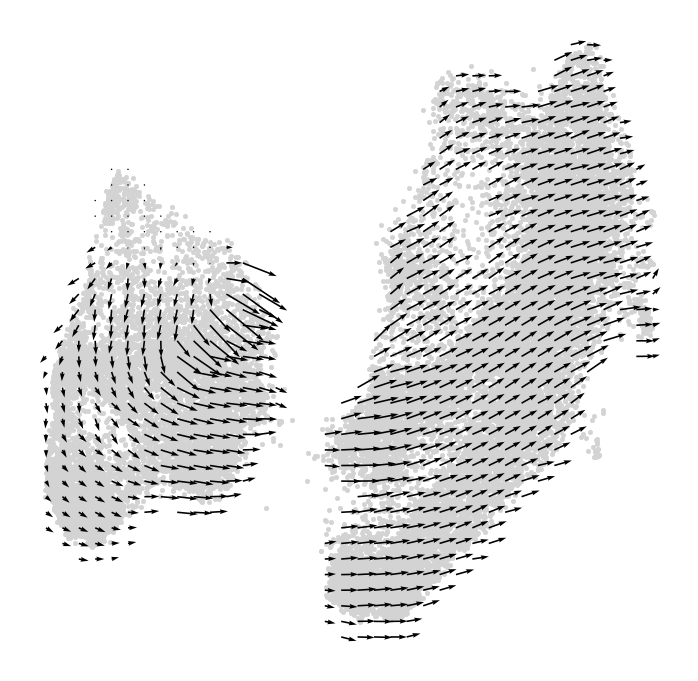

In [24]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [25]:
# Save gradient object if you want.
gradient.to_hdf5("/media/Scratch_SSD_Voyager/Blue/KPMP_10X/KPMP_Ref_analysis_12-2020/Celloracle2/aTAL.Module.celloracle.gradient")

In [26]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

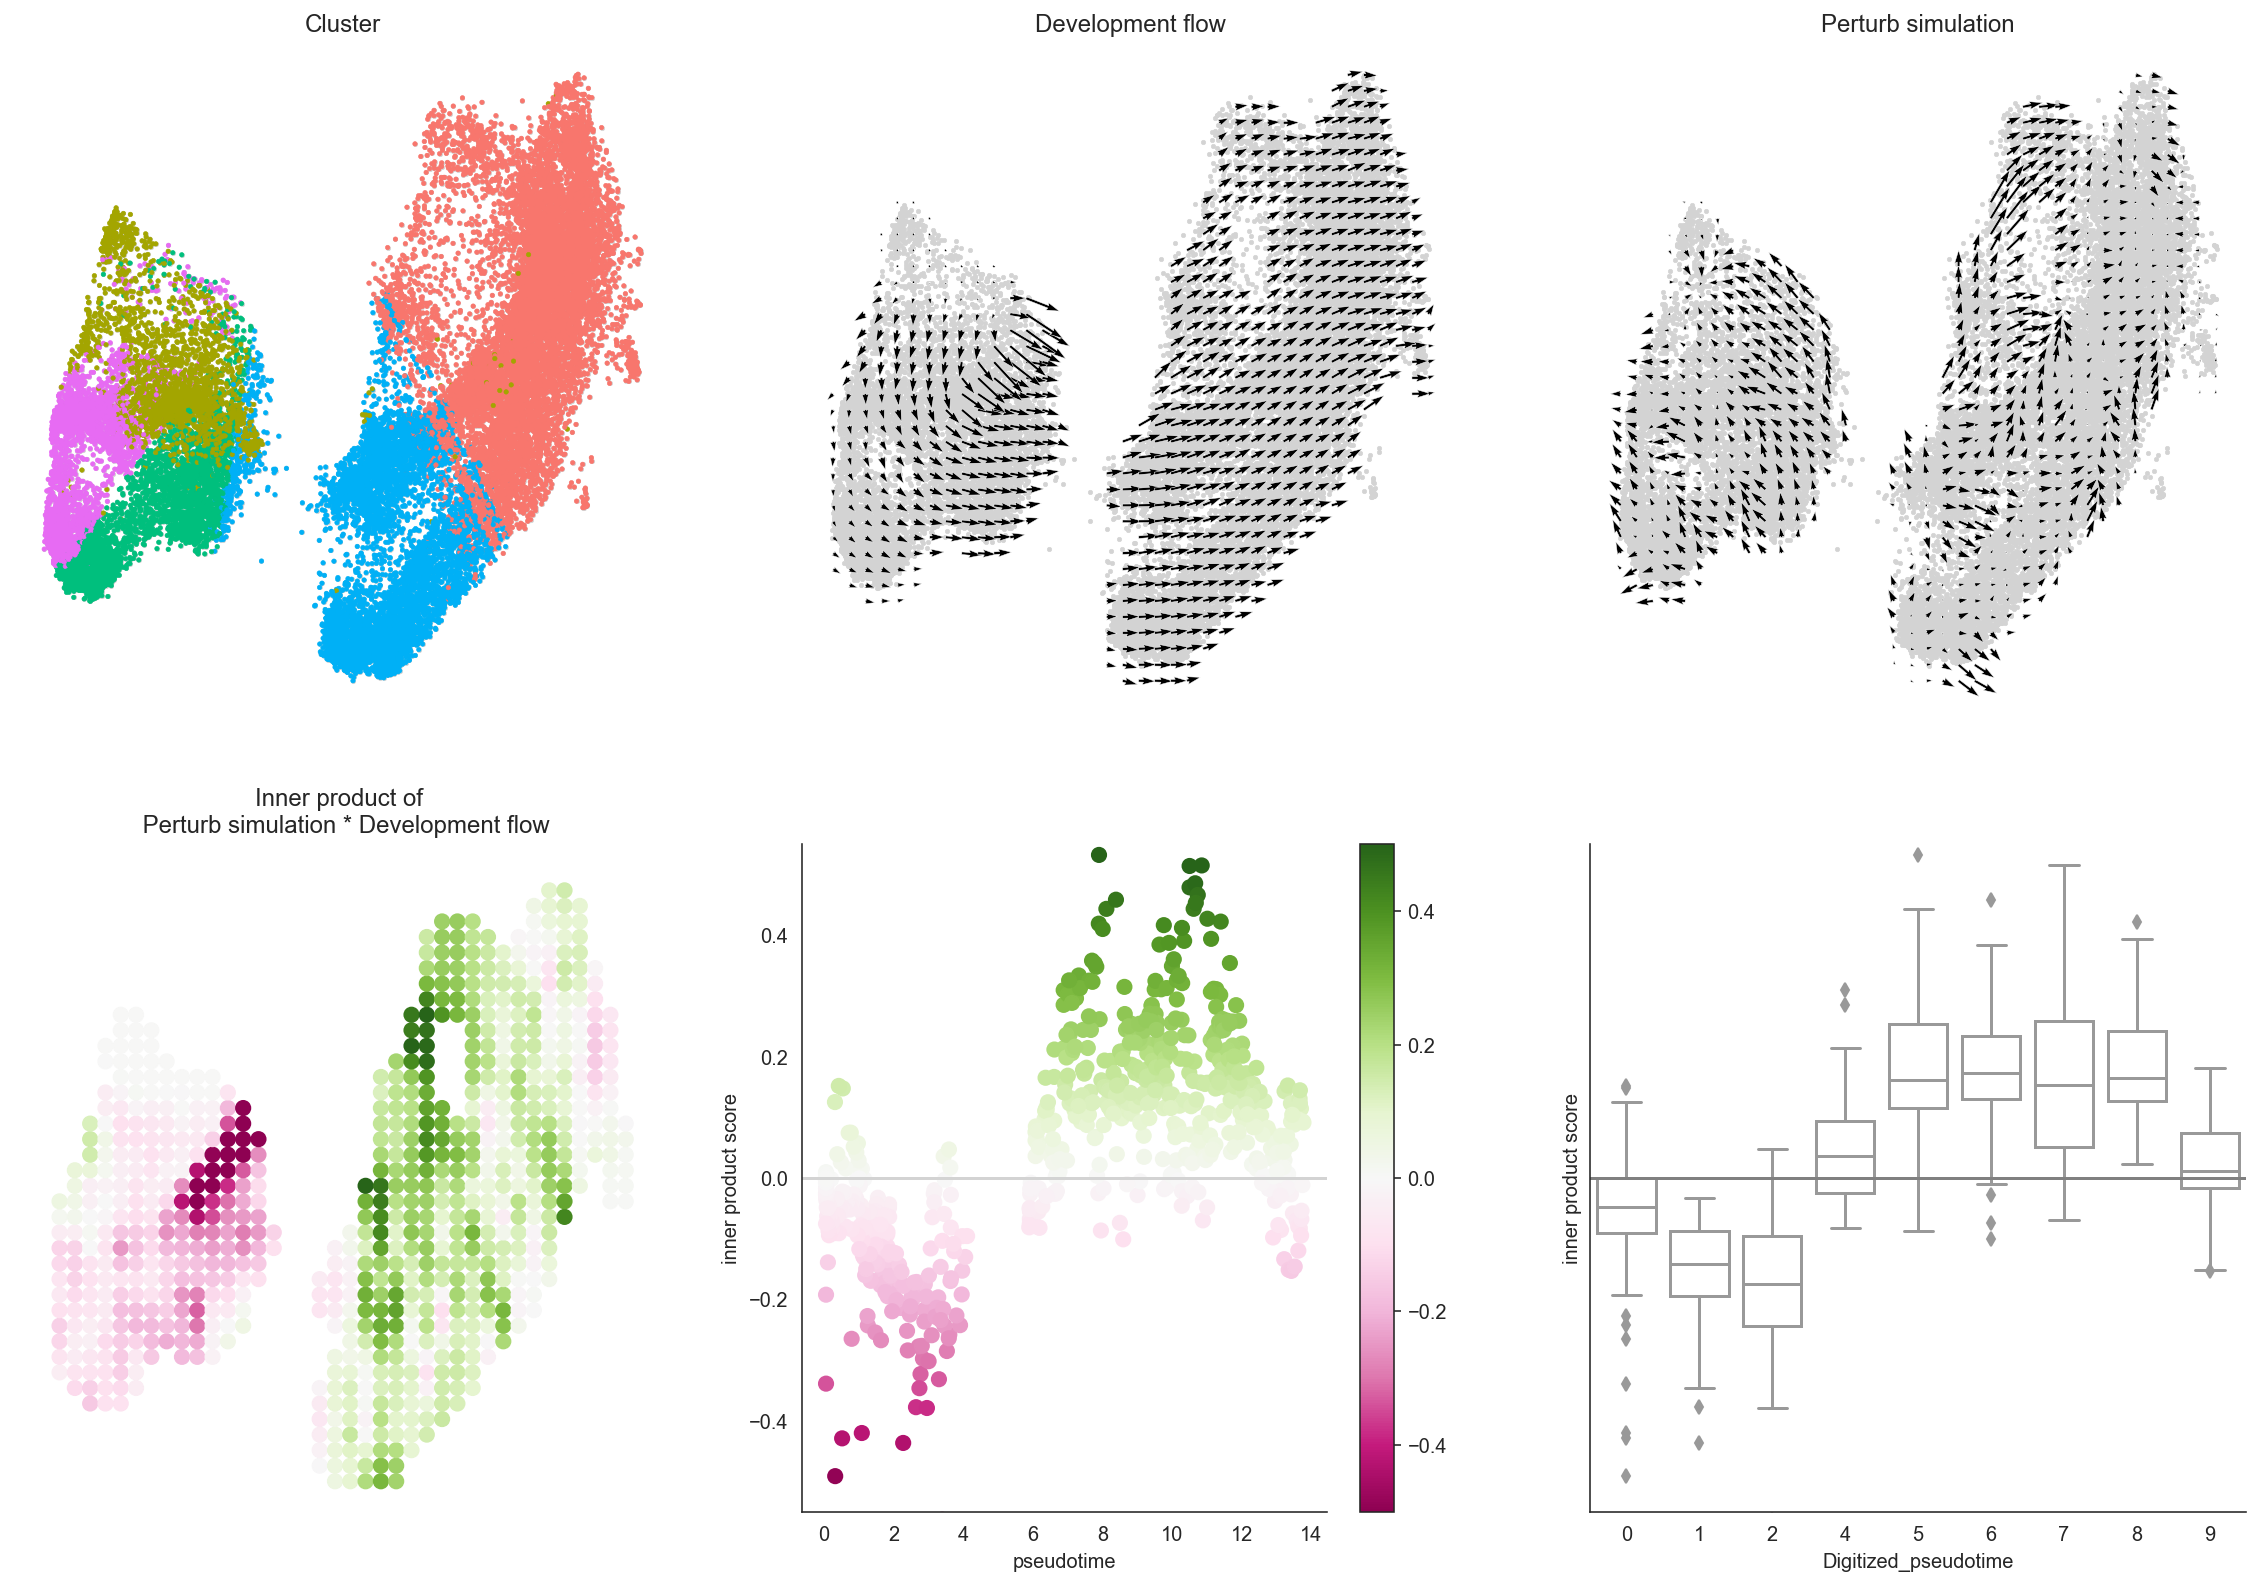

In [41]:
# Let's visualize the results
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=0.5)

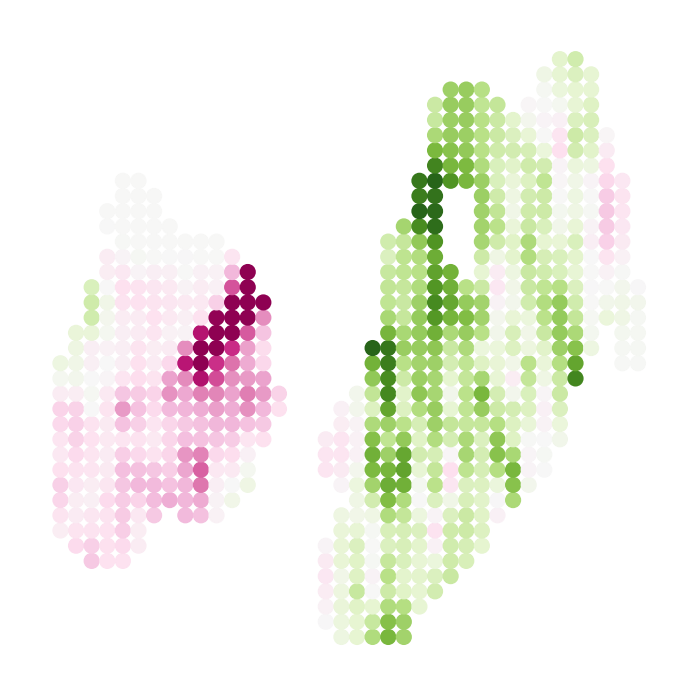

In [42]:
# Show perturbation scores
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.5, s=50, ax=ax)

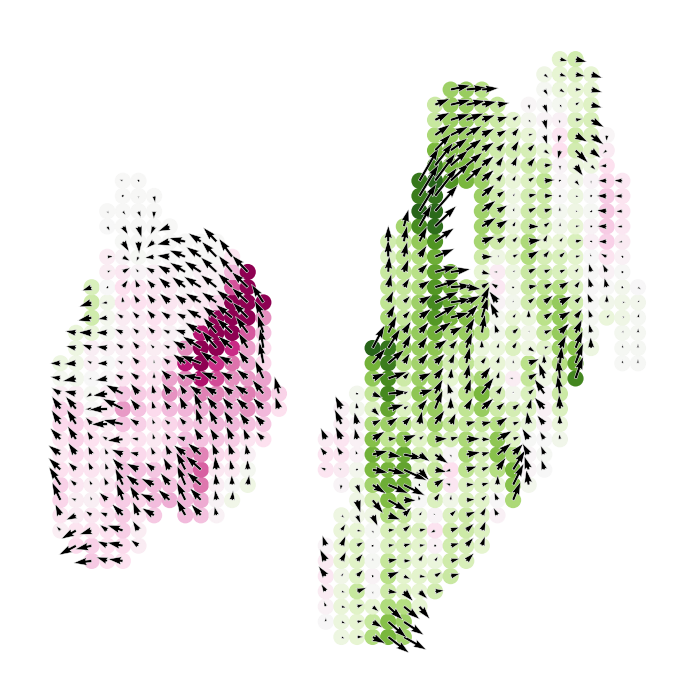

In [52]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.5, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)